## model 4: rf+ifscore(fs4)+fs4

In [14]:
import pandas as pd
import numpy as np

In [15]:
df = pd.read_csv('../models/rf_df_test_fsborda_ifscore_pred.csv',sep=';', index_col=0)

In [16]:
df.head()

,var38,saldo_var5,var3,saldo_medio_var5_hace3,...,TARGET,iforest_fsborda_score,prob_0,prob_1
50595,77930.250000,781.47,2,42.03,...,0,0.298228,0.901753,0.098247
5252,165125.040000,3.00,2,54195.09,...,0,0.302488,0.911249,0.088751
21956,82636.440000,60.00,2,45.51,...,0,0.294744,0.923321,0.076679
42714,67460.550000,293.70,2,772.29,...,0,0.299054,0.734853,0.265147
18494,117310.979016,3.00,2,1.86,...,0,0.294787,0.917923,0.082077


prob_0	= probabilidade de estar satisfeito  
prob_1 = probabilidade de churn

In [17]:
def ks(data=None,target=None, prob=None):
    ## finding at: https://www.listendata.com/2019/07/KS-Statistics-Python.html
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 5)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2}'.format).astype(float) * 100
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2}'.format).astype(float) * 100
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2}'.format).astype(float) * 100
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2}'.format).astype(float) * 100
    kstable.index = range(1,6)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    # print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [18]:
from scipy.stats import ks_2samp
yhat = df['prob_1']
y = df['TARGET']
def ks_stat(y, yhat):
    return ks_2samp(yhat[y==1], yhat[y!=1]).statistic
ks_stat(y, yhat)

0.49733143469370783

In [19]:
import seaborn as sns

In [20]:
target_0 = df[df['TARGET'] == 0]['prob_1'].values
target_1 = df[df['TARGET'] == 1]['prob_1'].values


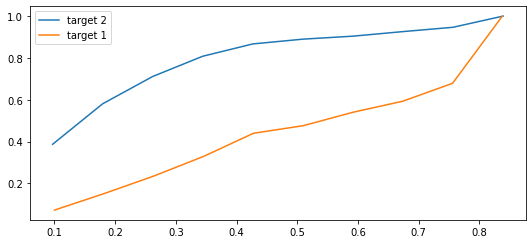

In [21]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = target_0
count, bins_count = np.histogram(data, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="target 2")

data1 = target_1
count1, bins_count1 = np.histogram(data1, bins=10)
pdf1= count1 / sum(count1)
cdf1 = np.cumsum(pdf1)
plt.plot(bins_count1[1:], cdf1, label="target 1")


plt.legend()
plt.show()

In [22]:
from scipy.stats import ks_2samp
yhat = df['prob_1']
y = df['TARGET']
def ks_stat(y, yhat):
    return ks_2samp(yhat[y==1], yhat[y!=1]).statistic
ks_stat(y, yhat)

0.49733143469370783

In [23]:
results_quintil = ks(df, target='TARGET', prob='prob_1')
results_quintil

KS is 47.9% at decile 1


,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.349352,0.839060,397,2549,65.0,17.0,65.0,17.0,47.9
2,0.198376,0.348758,102,3034,17.0,21.0,82.0,38.0,44.0
3,0.106578,0.198372,57,2983,9.4,20.0,92.0,59.0,32.9
4,0.054186,0.106567,38,3003,6.3,21.0,98.0,79.0,18.6
5,0.014474,0.054181,13,3028,2.1,21.0,100.0,100.0,0.0


In [24]:
from sklearn.metrics import roc_auc_score

print("Roc Auc: ",roc_auc_score(df['TARGET'], df['prob_1']))
print("Gini: ",2*(roc_auc_score(df['TARGET'], df['prob_1']))-1)

Roc Auc:  0.80855762490521
Gini:  0.61711524981042


In [25]:
results_quintil.columns = ['min_prob','max_prob','Qtd de eventos (Target)','Qtd de não-eventos (Target)','% de eventos no Decil','% de não-eventos no Decil','% de evento acumulados','% de não-evento acumulados','KS']
results_quintil.to_csv("results_model4_rf_ifscore_fs4.csv",sep=';')